- Grid data for habitat and elevation in the same area
- CPD tables for SLR - bins of same range
- Discritization of VLM - bins of same size (~ same number of points) (3 bins?)
- Elevation: about 6 classes

In [1]:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy.interpolate import griddata
import rasterio
from rasterio.plot import show
import georasters as gr

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


# Map overlay

In [2]:
dataset = rasterio.open('../Week 6/Elevation.tif')
elevation = dataset.read(1)

In [3]:
elevation_new = elevation.astype('float')
elevation_new[elevation_new == 32767] = np.nan

In [4]:
file = gr.from_file('../Week 6/Elevation.tif')
elevation_df = file.to_geopandas()

In [5]:
habitat_path = r"../Week 6/UAE_habitats_new1.shp"
habitat = gpd.read_file(habitat_path)

In [6]:
bounds = habitat.total_bounds
bounds

array([51.45556052, 22.63150743, 56.01812514, 25.65303804])

In [7]:
# f, ax = plt.subplots(1, 1, figsize=(14, 10))
# ax = habitat.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.25, 1))
# plt.scatter(x=[bounds[0], bounds[0], bounds[2], bounds[2]],
#             y=[bounds[1], bounds[3], bounds[1], bounds[3]], s=300, marker='x', c='r')
# plt.show()

In [8]:
habitat.head(2)

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry
0,1,1,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,7524.321019,2.115300e+06,Intertidal Habitats,"POLYGON ((53.99011 24.13066, 53.99039 24.13065..."
1,2,2,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,48704.931412,7.777595e+06,Intertidal Habitats,"POLYGON ((54.07207 24.15920, 54.07776 24.15455..."


In [9]:
elevation_df.head(2)

,row,col,value,x,y,geometry
0,0,2347,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014..."
1,0,2348,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014..."


In [10]:
elevation_df_new = elevation_df.to_crs("EPSG:4326")

In [11]:
# This has been running for half an hour without any result, I give up
# overlay = gpd.overlay(habitat, elevation_df_new, how='intersection')

# Network

In [12]:
import pgmpy.models
import pgmpy.inference
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import pylab

<img src="model.png"></img>

In [13]:
model = pgmpy.models.BayesianModel([('SLR', 'AE'),
                                    ('VLM', 'AE'),
                                    ('E', 'AE'),
                                    ('E', 'H'),
                                    ('H', 'CR'),
                                    ('AE', 'CR')])

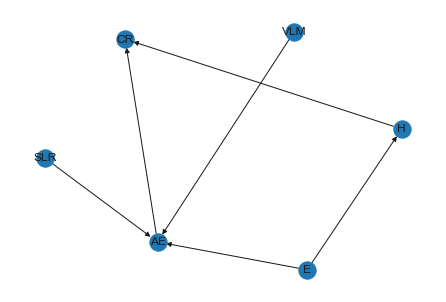

In [14]:
nx.draw(model, with_labels=True)

## Sea level rise

In [15]:
cpd_slr = TabularCPD('SLR', 4, [[0.25], [0.25], [0.25], [0.25]],
                     state_names={'SLR': ['0 - 0.25', '>0.25 - 0.5', '>0.5 - 0.75', '>0.75 - 2']})

In [16]:
model.add_cpds(cpd_slr)

## Vertical land movement

In [17]:
# cpd_vlm = TabularCPD('VLM', 3, [[0.33], [0.33], [0.33]],
#                      state_names={'VLM'})

In [25]:
vlm_df = pd.read_excel('../Week 6/data.xls')
vlm = vlm_df.drop(columns=['Station', 'VLM_std'])
vlm.head()

,Longitude,Latitude,VLM
0,54.684594,24.796595,-0.207
1,54.115618,24.303783,1.413
2,53.848164,24.056855,-0.856
3,53.141386,24.147625,-0.724
4,52.587928,24.171598,1.812


In [59]:
vlm['Bins'] = pd.qcut(vlm.VLM, q=3, labels=['Bin 1', 'Bin 2', 'Bin 3'])
vlm['Intervals'] = pd.qcut(vlm.VLM, q=3)
vlm.head()

,Longitude,Latitude,VLM,Bins,Intervals
0,54.684594,24.796595,-0.207,Bin 2,"(-0.517, 0.92]"
1,54.115618,24.303783,1.413,Bin 3,"(0.92, 2.471]"
2,53.848164,24.056855,-0.856,Bin 1,"(-1.208, -0.517]"
3,53.141386,24.147625,-0.724,Bin 1,"(-1.208, -0.517]"
4,52.587928,24.171598,1.812,Bin 3,"(0.92, 2.471]"


In [96]:
vlm_bins = pd.DataFrame(vlm.Bins.value_counts())
vlm_bins['Probability'] = vlm_bins.Bins / vlm_bins.Bins.sum()
vlm_bins

,Bins,Probability
Bin 1,9,0.333333
Bin 2,9,0.333333
Bin 3,9,0.333333


In [102]:
vlm_statenames = list(vlm_bins.index)
vlm_statenames

['Bin 1', 'Bin 2', 'Bin 3']

In [176]:
vlm_cpd = np.array(vlm_bins.Probability).reshape(-1, 1)
vlm_cpd

array([[0.33333333],
       [0.33333333],
       [0.33333333]])

In [104]:
cpd_vlm = TabularCPD('VLM', 3, vlm_cpd,
                     state_names={'VLM': vlm_statenames})

In [106]:
model.add_cpds(cpd_vlm)

## Elevation

Length of dataframe = number of non-NaN values in array

In [113]:
unique, counts = np.unique((elevation != 32767), return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0 2642257]
 [      1 1789661]]


In [115]:
elevation_df.shape

(1789661, 6)

In [140]:
elev = elevation_df[['value']]
elev.head()

,value
0,1.0
1,0.0
2,1.0
3,1.0
4,2.0


In [121]:
elev_min, elev_max = elev.value.min(), elev.value.max()
elev_min, elev_max

(-89.0, 83.0)

Elevation range: -10 to <-1, -1 to <0, 0 to 1, >1 to 5, >5 to 10, >10\
Currently: use min and max

In [130]:
# Does not work
# interval_0 = pd.Interval(elev_min, -1, closed="left")
# interval_1 = pd.Interval(-1, 0, closed="left")
# interval_2 = pd.Interval(0, 1, closed="both")
# interval_3 = pd.Interval(1, 5, closed="right")
# interval_4 = pd.Interval(5, 10, closed="right")
# interval_5 = pd.Interval(10, elev_max, closed="right")
# intervals_list = [interval_0, interval_1, interval_2, interval_3, interval_4, interval_5]
# elev_intervals = pd.IntervalIndex.from_intervals(intervals_list)

In [132]:
elev_intervals = pd.IntervalIndex.from_tuples([(elev_min-1, -1), (-1, 0), (0, 1),
                                               (1, 5), (5, 10), (10, elev_max+1)])
elev_intervals

IntervalIndex([(-90.0, -1.0], (-1.0, 0.0], (0.0, 1.0], (1.0, 5.0], (5.0, 10.0], (10.0, 84.0]],
              closed='right',
              dtype='interval[float64]')

In [134]:
elev_intervals_labels = ['(-90.0, -1.0]', '(-1.0, 0.0]', '(0.0, 1.0]',
                         '(1.0, 5.0]', '(5.0, 10.0]', '(10.0, 84.0]']

In [141]:
# labels arg is ignored if bins arg is of type IntervalIndex
# elev['Bins'] = pd.cut(elev.value, elev_intervals, labels=['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6'])
elev['Intervals'] = pd.cut(elev.value, elev_intervals, labels=False)

<ipython-input-141-893aa0db0ff6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elev['Intervals'] = pd.cut(elev.value, elev_intervals, labels=False)


In [142]:
elev.head()

,value,Intervals
0,1.0,"(0.0, 1.0]"
1,0.0,"(-1.0, 0.0]"
2,1.0,"(0.0, 1.0]"
3,1.0,"(0.0, 1.0]"
4,2.0,"(1.0, 5.0]"


In [157]:
elev_bins = pd.DataFrame(elev.Intervals.value_counts())
elev_bins.sort_index(inplace=True)
elev_bins['Probability'] = elev_bins.Intervals / elev_bins.Intervals.sum()
elev_bins

,Intervals,Probability
"(-90.0, -1.0]",156081,0.087213
"(-1.0, 0.0]",184253,0.102954
"(0.0, 1.0]",205379,0.114759
"(1.0, 5.0]",603235,0.337067
"(5.0, 10.0]",231449,0.129326
"(10.0, 84.0]",409264,0.228682


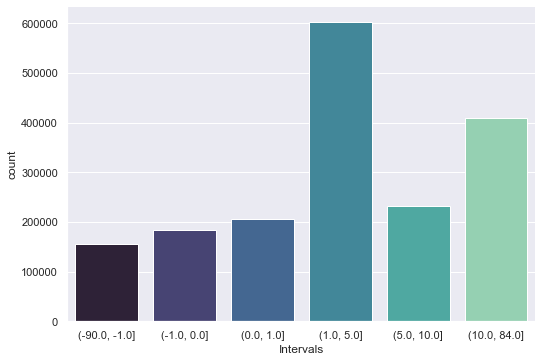

In [155]:
sns.catplot(x="Intervals", kind="count", palette="mako", data=elev, height=5, aspect=1.5)

<AxesSubplot:ylabel='Probability'>

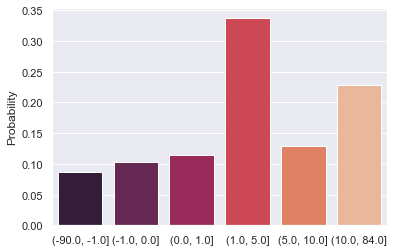

In [170]:
sns.barplot(x=elev_bins.index, y="Probability", palette="rocket", data=elev_bins)

In [174]:
elev_statenames = ['(-90.0, -1.0]', '(-1.0, 0.0]', '(0.0, 1.0]',
                   '(1.0, 5.0]', '(5.0, 10.0]', '(10.0, 84.0]']
elev_statenames

['(-90.0, -1.0]',
 '(-1.0, 0.0]',
 '(0.0, 1.0]',
 '(1.0, 5.0]',
 '(5.0, 10.0]',
 '(10.0, 84.0]']

In [177]:
elev_cpd = np.array(elev_bins.Probability).reshape(-1, 1)
elev_cpd

array([[0.08721261],
       [0.10295413],
       [0.11475861],
       [0.33706663],
       [0.12932561],
       [0.22868242]])

In [178]:
cpd_elev = TabularCPD('E', 6, elev_cpd,
                      state_names={'E': elev_statenames})
model.add_cpds(cpd_elev)

- Habitat & elevation: crop the habitat map using boundaries of elevation map first then try join or overlay
- Also try griddata
- VLM: use interpolation map
- User input for number of bins (VLM) (later, keep 3 for now)